<a href="https://colab.research.google.com/github/lsteffenel/NumbaCuda/blob/main/Introduction_CUDA_Python_avec_Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Avant de commencer

L'exécution de ces notebooks sur Colab nécessite deux choses (au 4/2/2025) :
1. des resources GPU
  * Menu "Exécution" -> "Modifier le type d'exécution"
2. D'utiliser une version plus ancienne de Colab en raison de certaines incompatibilités du pilote Nvidia
  * Menu "Outils" -> "Pallette de commandes". Cherchez "version" dans la barre et sélectionnez l'option "Utiliser la version d'environnement d'exécution de remplacement"



# Introduction à CUDA Python avec Numba


Dans cette première section, vous apprendrez d'abord à utiliser Numba pour compiler des fonctions pour la CPU, et recevrez une introduction au fonctionnement interne du compilateur Numba. Vous apprendrez ensuite comment accélérer par GPU les fonctions de tableau NumPy, ainsi que certaines techniques pour déplacer efficacement des données entre un hôte CPU et un périphérique GPU.


## C'est quoi Numba ?

Numba est un compilateur de fonctions **just-in-time**, qui permet d'accélérer des codes numériques Python autant sur CPU que sur GPU :

 * **compilateur de fonction**: Numba compile des fonctions Python, au lieu de la totalité de l'application. Lors de l'exécution, Numba fait appel à ces fonctions compilées.
 * **compilateur typé**: Numba accélère les fonctions en les traduisant vers C ou Assembler. Pour cela, il nous permet d'indiquer le type des variables pour faire un code plus rapide.
 * **just-in-time**: Numba traduit et compile les functions lors de leur premier appel. La fonction compilée reste en cache pour des appels futurs.  
 * **orienté données numériques **: Numba est optimisz pour des données numériques telles que `int`, `float`, et `complex`.  Il y a très peu de support à des strings et probablement elles ne passent pas sur un GPU. La meilleure façon d'utiliser Numba est de s'appuier sur des arrays NumPy.

## Premiers pas : Compiler pour le CPU

Numba peut être utilisé pour optimiser le code pour un CPU ou un GPU. En guise d'introduction, écrivons notre première fonction Numba et compilons-la pour le **CPU**.

Le compilateur Numba est généralement activé en appliquant un [**décorateur de fonction**](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators) à une fonction Python. Les décorateurs sont des annotations qui transforment les fonctions Python qu'ils décorent, en utilisant une syntaxe très simple. Ici, nous utiliserons le décorateur de compilation CPU de Numba `@jit` :


In [1]:
from numba import jit
import math

# This is the function decorator syntax and is equivalent to `hypot = jit(hypot)`.
# The Numba compiler is just a function you can call whenever you want!
@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

Essayons notre calcul d’hypoténuse :

In [2]:
hypot(3.0, 4.0)

5.0

Nous donnerons des détails plus tard, mais pour l'instant sachez que la première fois que nous appelons `hypot`, le compilateur est déclenché et compile une implémentation en code machine de la fonction pour les valeurs de type `float`. Numba enregistre également l'implémentation Python d'origine de la fonction dans l'attribut `.py_func`, afin que nous puissions appeler le code Python d'origine pour nous assurer d'obtenir la même réponse :


In [3]:
hypot.py_func(3.0, 4.0)

5.0

### Benchmarking

Une partie importante de l'utilisation de Numba consiste à mesurer les performances de votre nouveau code.

Voyons si nous avons réellement accéléré quelque chose : le moyen le plus simple de le faire dans un bloc-notes Jupyter, comme celui dans lequel cette session est exécutée, est d'utiliser la [fonction magique `%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit).

Commençons par mesurer la vitesse du Python d'origine :


In [4]:
%timeit hypot.py_func(3.0, 4.0)

717 ns ± 187 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


La fonction `%timeit` exécute l'instruction plusieurs fois pour obtenir une estimation précise du temps d'exécution. Elle renvoie également le meilleur temps par défaut, ce qui est utile pour réduire la probabilité que des événements d'arrière-plan affectent votre mesure. L'approche du meilleur des 3 garantit également que le temps de compilation lors du premier appel ne fausse pas les résultats :

In [5]:
%timeit hypot(3.0, 4.0)

207 ns ± 7.32 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba a fait du bon travail avec cette fonction. Elle est certainement plus rapide que la version Python pure. Bien sûr, la fonction `hypot` est déjà présente dans le module Python, voyons comment elle se compare :

In [6]:
%timeit math.hypot(3.0, 4.0)

153 ns ± 29.8 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


La fonction intégrée dans la bibliothèque math Python est encore plus rapide que Numba ! En effet, Numba introduit une surcharge à chaque appel de fonction qui est plus importante que la surcharge d'appel de fonction de Python lui-même.

Les fonctions extrêmement rapides (comme celle ci-dessus) en souffriront.

### Exercice : Utiliser Numba pour compiler une fonction pour le processeur

La fonction suivante utilise [la méthode de Monte Carlo pour déterminer Pi](https://academo.org/demos/estimating-pi-monte-carlo/). La fonction elle-même fonctionne déjà, ne vous inquiétez donc pas des détails de l'implémentation mathématique.

Complétez les deux `TODO` afin de compiler `monte_carlo_pi` avec Numba avant d'exécuter les 3 cellules suivantes qui :

1. Confirment que la version compilée se comporte de la même manière que la version non compilée.
2. Évaluent la version non compilée.
3. Évaluent la version compilée.

In [7]:
nsamples = 1000000

In [8]:
# TODO: Import Numba's just-in-time compiler function
import random

# TODO: Use the Numba compiler to compile this function
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [ ]:
# We will use numpy's `testing` library to confirm compiled and uncompiled versions run the same
from numpy import testing

# This assertion will fail until you successfully complete the exercise one cell above
testing.assert_almost_equal(monte_carlo_pi(nsamples), monte_carlo_pi.py_func(nsamples), decimal=2)

In [ ]:
%timeit monte_carlo_pi(nsamples)

In [ ]:
%timeit monte_carlo_pi.py_func(nsamples)

## Comment fonctionne Numba

Maintenant que vous avez un peu mis les mains dans le cambouis avec le compilateur Numba, regardons ce qui se passe réellement sous le capot. La première fois que nous avons appelé notre fonction `hypot` enveloppée dans Numba, le compilateur traduit le code en langages assembleur de bas niveau (LLVM) et le compile. Au passage, il associe des types aux variables.

Nous pouvons voir le résultat de l'inférence de type en utilisant la méthode `.inspect_types()`, qui imprime une version annotée du code source :

In [9]:
hypot.inspect_types()

hypot (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-1-0c62bf228b8e>
# --- LINE 6 --- 
# label 0
#   x = arg(0, name=x)  :: float64
#   y = arg(1, name=y)  :: float64

@jit

# --- LINE 7 --- 

def hypot(x, y):

    # --- LINE 8 --- 

    # Implementation from https://en.wikipedia.org/wiki/Hypot

    # --- LINE 9 --- 
    #   $2load_global.0 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   x.1 = call $2load_global.0(x, func=$2load_global.0, args=[Var(x, <ipython-input-1-0c62bf228b8e>:6)], kws=(), vararg=None, varkwarg=None, target=None)  :: (float64,) -> float64
    #   del x
    #   del $2load_global.0

    x = abs(x);

    # --- LINE 10 --- 
    #   $10load_global.3 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   y.1 = call $10load_global.3(y, func=$10load_global.3, args=[Var(y, <ipython-input-1-0c62bf228b8e>:6)], kws=(), vararg=None, var

Notez que les noms de type de Numba ont tendance à refléter [les noms de type NumPy](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html), donc un `float` Python est un `float64` (également appelé « double précision » dans d'autres langages). Il peut parfois être important de jeter un œil aux types de données dans le code GPU, car les performances des calculs `float32` et `float64` peuvent (selon le GPU) être très différentes sur les périphériques CUDA. Si votre algorithme peut obtenir des résultats corrects en utilisant `float32`, vous devriez probablement utiliser ce type de données, car le transtypage vers `float64` peut, selon le type de GPU, ralentir considérablement la fonction.

## Introduction à Numba pour le GPU avec les fonctions universelles NumPy (ufuncs)

Nous commencerons notre présentation de la programmation GPU dans Numba en expliquant comment compiler [les fonctions universelles NumPy \(ou ufuncs\)](https://docs.scipy.org/doc/numpy-1.15.1/reference/ufuncs.html) pour le GPU.

La chose la plus importante à savoir sur la programmation GPU lorsque nous commençons est que le matériel GPU est conçu pour le *parallélisme des données*. Le débit maximal est atteint lorsque le GPU calcule les mêmes opérations sur de nombreux éléments différents à la fois.

Les fonctions universelles NumPy, qui effectuent la même opération sur chaque élément d'un tableau NumPy, sont naturellement parallèles aux données, elles sont donc naturellement adaptées à la programmation GPU.

## Les fonctions universelles NumPy (ufuncs)

NumPy a le concept de fonctions universelles (« ufuncs »), qui sont des fonctions qui peuvent prendre des tableaux NumPy de dimensions variables, ou scalaires, et les exploiter élément par élément.

À titre d'exemple, nous utiliserons l'ufunc `add` de NumPy pour démontrer le mécanisme ufunc de base :

In [18]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b) # Returns a new NumPy array resulting from adding every element in `a` to every element in `b`

array([11, 22, 33, 44])

Ufuncs peut également combiner des scalaires avec des tableaux :

In [19]:
np.add(a, 100) # Returns a new NumPy array resulting from adding 100 to every element in `a`

array([101, 102, 103, 104])

Des tableaux de dimensions différentes, mais compatibles, peuvent également être combinés via une technique appelée [*broadcasting*](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html).

Le tableau de dimension inférieure sera répliqué pour correspondre à la dimensionnalité du tableau de dimension supérieure.

In [26]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

## Faire des ufuncs pour le GPU

Numba a la capacité de créer des ufuncs *compilés*, un processus généralement pas si simple impliquant du code C.

Avec Numba, vous implémentez simplement une fonction scalaire à exécuter sur toutes les entrées, vous la décorez avec `@vectorize`, et Numba déterminera les règles de diffusion pour vous.

Dans ce tout premier exemple, nous utiliserons le décorateur `@vectorize` pour compiler et optimiser un ufunc pour le **CPU**.

In [21]:
from numba import vectorize

@vectorize
def add_ten(num):
    return num + 10 # This scalar operation will be performed on each element

In [22]:
nums = np.arange(10)
add_ten(nums) # pass the whole array into the ufunc, it performs the operation on each element

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

Nous générons un ufunc qui utilise CUDA sur le GPU avec en plus une **signature de type explicite** et la définition de l'attribut `target`. L'argument de signature décrit les types à utiliser à la fois pour les arguments ufuncs et la valeur de retour :
```python
'return_value_type(argument1_value_type, argument2_value_type, ...)'
```

Voici un exemple simple d'un ufunc qui sera compilé pour un périphérique GPU compatible CUDA. Il attend deux valeurs `int64` et renvoie également une valeur `int64` :

In [23]:
@vectorize(['int64(int64, int64)'], target='cuda') # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y

In [24]:
add_ufunc(a, b)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([11, 22, 33, 44])

Pour un appel de fonction aussi simple, beaucoup de choses se sont produites !

* Compilation d'un noyau CUDA pour exécuter l'opération ufunc en parallèle sur tous les éléments d'entrée.
* Mémoire GPU allouée pour les entrées et la sortie.
* Copie des données d'entrée sur le GPU.
* Exécution du noyau CUDA (fonction GPU) avec les dimensions de noyau correctes compte tenu des tailles d'entrée.
* Copie du résultat du GPU vers le CPU.
* Renvoi du résultat sous forme de tableau NumPy sur l'hôte.

Comparé à une implémentation en C, le code Numba est remarquablement plus concis.

Vous vous demandez peut-être à quelle vitesse notre exemple simple est sur le GPU ? Voyons voir :

In [27]:
%timeit np.add(b, c)   # NumPy on CPU

1.39 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [28]:
%timeit add_ufunc(b, c) # Numba on GPU

1.03 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Attends, le GPU est *beaucoup plus lent* que le CPU ?? Pour le moment, c'est normal, car nous avons (délibérément) mal utilisé le GPU de plusieurs manières dans cet exemple. La façon dont nous avons mal utilisé le GPU aidera à clarifier quels types de problèmes sont bien adaptés au calcul GPU et lesquels sont mieux traités par le CPU :

* **Nos entrées sont trop petites** : le GPU atteint des performances grâce au parallélisme, en opérant sur des milliers de valeurs à la fois. Nos entrées de test n'ont que 4 et 16 entiers, respectivement. Nous avons besoin d'un tableau beaucoup plus grand pour même occuper le GPU.

* **Notre calcul est trop simple** : l'envoi d'un calcul au GPU implique une charge assez importante par rapport à l'appel d'une fonction sur le CPU. Si notre calcul n'implique pas suffisamment d'opérations mathématiques (souvent appelées « intensité arithmétique »), le GPU passera la plupart de son temps à attendre que les données se déplacent.
* **Nous copions les données vers et depuis le GPU** : le coût de la copie des données vers et depuis le GPU est souvent très important, alors il sera préférable d'exécuter plusieurs opérations GPU en séquence. Dans ces cas, il est logique d'envoyer des données au GPU et de les y conserver jusqu'à ce que tout notre traitement soit terminé.
* **Nos types de données sont plus grands que nécessaire** : Notre exemple utilise `int64` alors que nous n'en avons probablement pas besoin. Le code scalaire utilisant des types de données 32 et 64 bits s'exécute essentiellement à la même vitesse sur le processeur, et pour les types entiers, la différence peut ne pas être drastique, mais les types de données à virgule flottante 64 bits peuvent avoir un coût de performance significatif sur le GPU, selon le type de GPU.

L'arithmétique de base sur des flottants 64 bits peut être de 2x (architecture Pascal Tesla) à 24x (architecture Maxwell GeForce) plus lente que les flottants 32 bits. Si vous utilisez des GPU plus modernes (Volta, Turing, Ampere), cela pourrait être beaucoup moins préoccupant. NumPy utilise par défaut des types de données 64 bits lors de la création de tableaux, il est donc important de définir l'attribut [`dtype`](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.dtypes.html) ou d'utiliser la méthode [`ndarray.astype()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.astype.html) pour sélectionner des types 32 bits lorsque vous en avez besoin.

Compte tenu de ce qui précède, essayons un exemple plus rapide sur le GPU en effectuant une opération avec une intensité arithmétique beaucoup plus grande, sur une entrée beaucoup plus grande et en utilisant un type de données 32 bits.

**Remarque :** tout le code NumPy ne fonctionnera pas sur le GPU et, comme dans l'exemple suivant, nous devrons utiliser les fonctions « pi » et « exp » de la bibliothèque « math » au lieu de celles de NumPy. Veuillez consulter [la documentation Numba](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html) pour une couverture complète de la prise en charge de NumPy sur le GPU.


In [29]:
import math # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [30]:
import numpy as np
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test on a single element just to make sure it works
gaussian_pdf(x[0], 0.0, 1.0)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([0.20117155], dtype=float32)

In [31]:
import scipy.stats # for definition of gaussian distribution, so we can compare CPU to GPU time
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

32.7 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit gaussian_pdf(x, mean, sigma)

4.43 ms ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


C'est une amélioration assez importante, même en incluant la surcharge de copie de toutes les données vers et depuis le GPU. Les Ufunc qui utilisent des fonctions spéciales (`exp`, `sin`, `cos`, etc.) sur de grands ensembles de données fonctionnent particulièrement bien sur le GPU.

Pour terminer notre comparaison, définissons et chronométrons notre fonction `gaussian_pdf` lorsqu'elle est optimisée par Numba pour le **CPU** :

In [33]:
@vectorize
def cpu_gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [34]:
%timeit cpu_gaussian_pdf(x, mean, sigma)

11.8 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


C'est beaucoup plus rapide que la version CPU non compilée, mais beaucoup plus lent que celle accélérée par GPU.

## Fonctions de périphérique CUDA

Les fonctions Ufunc sont vraiment fantastiques si et quand vous souhaitez effectuer des opérations élément par élément, ce qui est une tâche très courante. Il existe cependant un certain nombre de fonctions qui ne correspondent pas à cette description.

Pour compiler des fonctions pour le GPU qui ne sont **pas** des fonctions vectorisées élément par élément, nous utilisons `numba.cuda.jit`.

Dans la section suivante de ce cours, nous travaillons intensivement avec `numba.cuda.jit`, mais pour l'instant, montrons comment l'utiliser pour décorer une fonction d'assistance, à utiliser par un ufunc accéléré par GPU, afin que vous n'ayez pas à entasser toute votre logique dans une seule définition ufunc.

Remarquez que `polar_to_cartesian` ci-dessous ne nécessite pas de signature de type, et aussi, qu'il lui est passé deux valeurs scalaires, contrairement aux ufuncs vectorisés que nous avons utilisés (et comme `polar_distance` ci-dessous) qui attendent des tableaux NumPy comme arguments.

L'argument `device=True` indique que la fonction décorée ne peut être appelée **que** à partir d'une fonction exécutée sur le GPU, et non à partir du code hôte du CPU :



In [35]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)

    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [36]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [37]:
polar_distance(rho1, theta1, rho2, theta2)

array([1.5648396 , 0.96388024, 1.3883667 , ..., 1.414845  , 2.572454  ,
       0.6035127 ], dtype=float32)

Notez que le compilateur CUDA intègre de manière agressive les fonctions de l'appareil, il n'y a donc généralement pas de surcharge pour les appels de fonction. De même, le « tuple » renvoyé par `polar_to_cartesian` n'est pas réellement créé en tant qu'objet Python, mais représenté temporairement en tant que structure, qui est ensuite optimisée par le compilateur.

## Instructions Python autorisées sur le GPU

Par rapport à des opérations supportés par Numba sur le CPU (qui est déjà limité), Numba sur le GPU a encore plus de limitations. Les instructions Python pris en charge incluent :

* `if`/`elif`/`else`
* Boucles `while` et `for`
* Opérateurs mathématiques de base
* Fonctions sélectionnées des modules `math` et `cmath`
* Tuples

Voir [le manuel Numba](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) pour plus de détails.

### Exercice : accélération d'une fonction par le GPU

Nous allons accélérer une fonction de « suppression du zéro ». Une opération courante lorsque l'on travaille avec des formes d'onde consiste à forcer toutes les valeurs d'échantillon inférieures à une certaine magnitude absolue à être nulles, afin d'éliminer le bruit de faible amplitude. Créons quelques exemples de données :

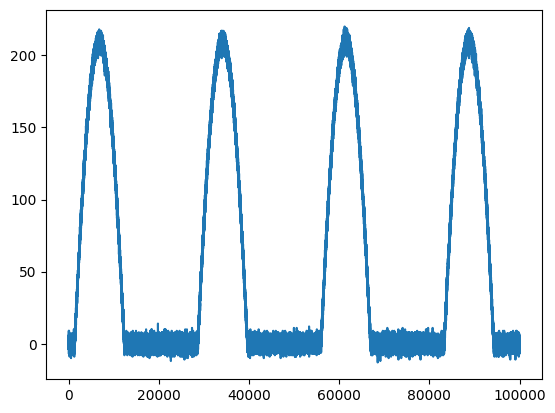

In [38]:
# This allows us to plot right here in the notebook
%matplotlib inline

# Hacking up a noisy pulse train
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Décorez maintenant cette fonction `zero_suppress` pour l'exécuter en tant qu'ufunc vectorisé sur le périphérique CUDA.

In [ ]:
# TODO vectorize the function
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

In [ ]:
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15))

## Gestion de la mémoire GPU

Jusqu'à présent, nous avons utilisé des tableaux NumPy sur le processeur comme entrées et sorties pour nos fonctions GPU. Pour plus de commodité, Numba a transféré automatiquement ces données au GPU pour que celui-ci puisse les exploiter. Avec ce transfert de données implicite, Numba, agissant de manière conservatrice, transférera automatiquement les données au processeur après le traitement. Comme vous pouvez l'imaginer, il s'agit d'une opération qui prend beaucoup de temps.

Le [Guide des meilleures pratiques CUDA](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html) indique :

> **Haute priorité** : minimiser le transfert de données entre l'hôte et l'appareil, même si cela signifie exécuter certains noyaux sur l'appareil qui ne présentent pas de gains de performances par rapport à leur exécution sur le processeur hôte.

Dans cette optique, nous devons réfléchir à la manière d'empêcher ce transfert automatique de données vers l'hôte afin de pouvoir effectuer un travail supplémentaire sur les données, en ne payant le prix de leur recopie vers l'hôte que lorsque nous sommes vraiment prêts.

Pour ce faire, nous créons des **tableaux de périphériques CUDA** et les transmettons à nos fonctions GPU. Les tableaux de périphériques ne seront pas automatiquement transférés vers l'hôte après le traitement et pourront être réutilisés comme nous le souhaitons sur le périphérique avant de les renvoyer, en tout ou en partie, vers l'hôte, et seulement si nécessaire.

Pour démontrer, créons à nouveau notre exemple d'addition ufunc :

In [39]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [40]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [41]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.54 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Le module `numba.cuda` inclut une fonction qui copiera les données de l'hôte sur le GPU et renverra un tableau de périphériques CUDA.

Notez que lorsque nous essayons d'imprimer le contenu du tableau de périphériques, nous obtenons uniquement des informations sur le tableau, et non son contenu réel. Cela est dû au fait que les données se trouvent sur le périphérique et que nous devons les retransférer vers l'hôte afin d'imprimer ses valeurs, ce que nous montrerons comment faire plus tard :

In [42]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Les tableaux de périphériques peuvent être transmis aux fonctions CUDA tout comme les tableaux NumPy, mais sans la surcharge de copie :

In [ ]:
%timeit add_ufunc(x_device, y_device)

Étant donné que `x_device` et `y_device` sont déjà présents sur le périphérique, ce test est beaucoup plus rapide.

Nous allouons toujours un tableau de périphériques pour la sortie de l'ufunc et le copions sur l'hôte, même si dans la cellule ci-dessus nous n'assignons pas réellement le tableau à une variable. Pour éviter cela, nous pouvons créer le tableau de sortie avec la fonction [`numba.cuda.device_array()`](https://numba.pydata.org/numba-doc/dev/cuda-reference/memory.html#numba.cuda.device_array) :

In [44]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

Et puis nous pouvons utiliser un argument de mot-clé spécial « out » pour l'ufunc pour spécifier le tampon de sortie :

In [45]:
%timeit add_ufunc(x_device, y_device, out=out_device)

249 µs ± 9.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Cet appel à `add_ufunc` n'implique aucun transfert de données entre l'hôte et le périphérique et s'exécute donc le plus rapidement. Si et quand nous voulons ramener un tableau de périphériques dans la mémoire de l'hôte, nous pouvons utiliser la méthode `copy_to_host()` :

In [ ]:
out_host = out_device.copy_to_host()
print(out_host[:10])

Vous pensez peut-être que nous ne comparons pas ici des pommes avec des pommes puisque nous n'avons pas évalué les appels `to_device` lors de l'utilisation des tableaux de périphériques bien que les transferts de données implicites soient comptabilisés dans l'évaluation lorsque nous utilisons les tableaux d'hôtes `a` et `b`, et vous auriez raison. Bien entendu, notre fonction `add_func` n'est pas particulièrement bien adaptée au GPU, l'exemple n'avait pour but que de démontrer comment les transferts peuvent être éliminés.

Assurez-vous d'évaluer vos transferts de données lorsque vous déterminez si un passage au GPU en vaut la peine.

De plus, Numba fournit des méthodes supplémentaires pour gérer la mémoire de l'appareil et le transfert de données, consultez [la documentation](https://numba.pydata.org/numba-doc/dev/cuda/memory.html) pour plus de détails.

### Exercice : Optimiser le mouvement de la mémoire

Soit donné ces ufuncs :

In [47]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Dans la cellule ci-dessous, il y a actuellement un aller-retour inutile de données vers l'hôte, puis de nouveau vers le périphérique, entre les appels à `make_pulses` et `add_ufunc`.

Mettez à jour la cellule ci-dessous pour utiliser les allocations de périphériques afin qu'il n'y ait qu'une seule copie vers le périphérique avant l'appel à `make_pulses` et une seule copie vers l'hôte après l'appel à `add_ufunc`.

In [48]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


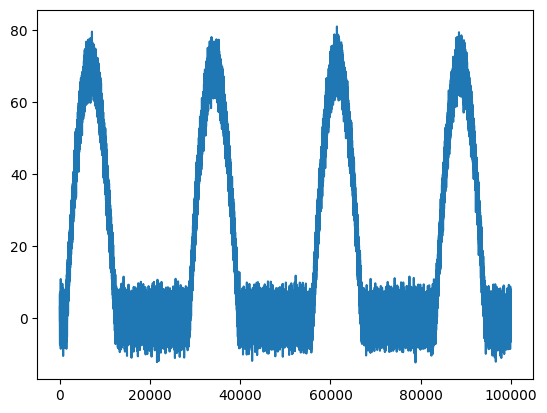

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

## Exercice final

Ce sujet de TD/TP fait partie de la certification "Fundamentals of Accelerated Computing with CUDA Python" de NVidia. On vous encourage à effectuer cet exercice et garder la réponse, ça vous permettra plus tard d'obtenir la certification (il y a 3 modules à compléter, celui-ci est le premier).

**Veuillez lire attentivement les instructions avant de commencer votre travail pour garantir les meilleures chances de réussir l'évaluation.**

### Accélérez les calculs de réseaux neuronaux

Vous allez refactoriser une version simple d'un code qui effectue le travail nécessaire pour créer une couche cachée dans un réseau neuronal. Il normalise les valeurs de niveaux de gris, les pondère et applique une fonction d'activation.

Votre tâche consiste à déplacer ce travail vers le GPU en utilisant les techniques que vous avez apprises tout en préservant l'exactitude des calculs.

### Charger les imports et initialiser les valeurs

Exécutez cette cellule pour importer les bibliothèques requises et initialiser les valeurs avant de commencer votre travail ci-dessous.

In [ ]:
# You should not modify this cell, it contains imports and initial values needed to do work on either
# the CPU or the GPU.

import numpy as np
from numba import cuda, vectorize

# Our hidden layer will contain 1M neurons.
# When you assess your work below, this value will be automatically set to 100M.
n = 1000000

greyscales = np.floor(np.random.uniform(0, 255, n).astype(np.float32))
weights = np.random.normal(.5, .1, n).astype(np.float32)

### Accélération GPU

Vous devrez apporter des modifications à chacune des 3 cellules de cette section avant d'évaluer votre travail ci-dessous. Suivez les instructions dans les commentaires.

In [ ]:
# As you will recall, `numpy.exp` works on the CPU, but, cannot be used in GPU implmentations.
# This import will work for the CPU-only boilerplate code provided below, but
# you will need to modify this import before your GPU implementation will work.
from numpy import exp

In [ ]:
# Modify these 3 function calls to run on the GPU.
def normalize(grayscales):
    return grayscales / 255

def weigh(values, weights):
    return values * weights

def activate(values):
    return ( exp(values) - exp(-values) ) / ( exp(values) + exp(-values) )

In [ ]:
# Modify the body of this function to optimize data transfers and therefore speed up performance.
# As a constraint, even after you move work to the GPU, make this function return a host array.
def create_hidden_layer(n, greyscales, weights, exp, normalize, weigh, activate):

    normalized = normalize(greyscales)
    weighted = weigh(normalized, weights)
    activated = activate(weighted)

    # The assessment mechanism will expect `activated` to be a host array, so,
    # even after you refactor this code to run on the GPU, make sure to explicitly copy
    # `activated` back to the host.
    return activated

### Validez votre travail

Utilisez cette section pour tester et débuguer votre code

In [ ]:
# You probably don't need to edit this cell, unless you change the name of any of the values being passed as
# arguments to `create_hidden_layer` below.
arguments = {"n":n,
            "greyscales": greyscales,
            "weights": weights,
            "exp": exp,
            "normalize": normalize,
            "weigh": weigh,
            "activate": activate}

In [ ]:
# Use this cell (and feel free to create others) to self-assess your function
a = create_hidden_layer(**arguments)
print(a)

### Soumettre le code à NVIDIA

Enregistrer les cellules que vous avez modifié. L'enseignant vous montrera comment créer un compte Nvidia Developper afin de vous inscrire dans la certification et soumettre votre réponse.